<a href="https://colab.research.google.com/github/filipe-research/tutorial_noisylabels/blob/main/codes/tutorial_sibgrapi20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: How to train your model when you cannot trust on the annotations? - SIGBRAPI 2020

Authors: Filipe Cordeiro, Gustavo Carneiro\
github: https://github.com/filipe-research/tutorial_noisylabels

https://www.youtube.com/watch?v=Tu9xwEVDtzA

DATASET: 
"MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

[Read more.](https://www.kaggle.com/c/digit-recognizer)


<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

# Setup

import libraries, hyperparameters and main methods

In [1]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
import seaborn as sn
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#@title Define Hyperparameters

training_size= 2000
num_epochs = 50 # number of times which the entire dataset is passed throughout the model
batch_size = 128 # the size of input data took for one iteration
lr = 1e-3 # size of step
seed=123

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))

In [4]:
# Reduce training size  (just for fast training during the tutorial)
train_data.data = train_data.data[:training_size]
train_data.targets = train_data.targets[:training_size]

In [5]:
#generate dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True,num_workers=1,pin_memory=False)

eval_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = False,num_workers=1,pin_memory=False)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False,num_workers=1)

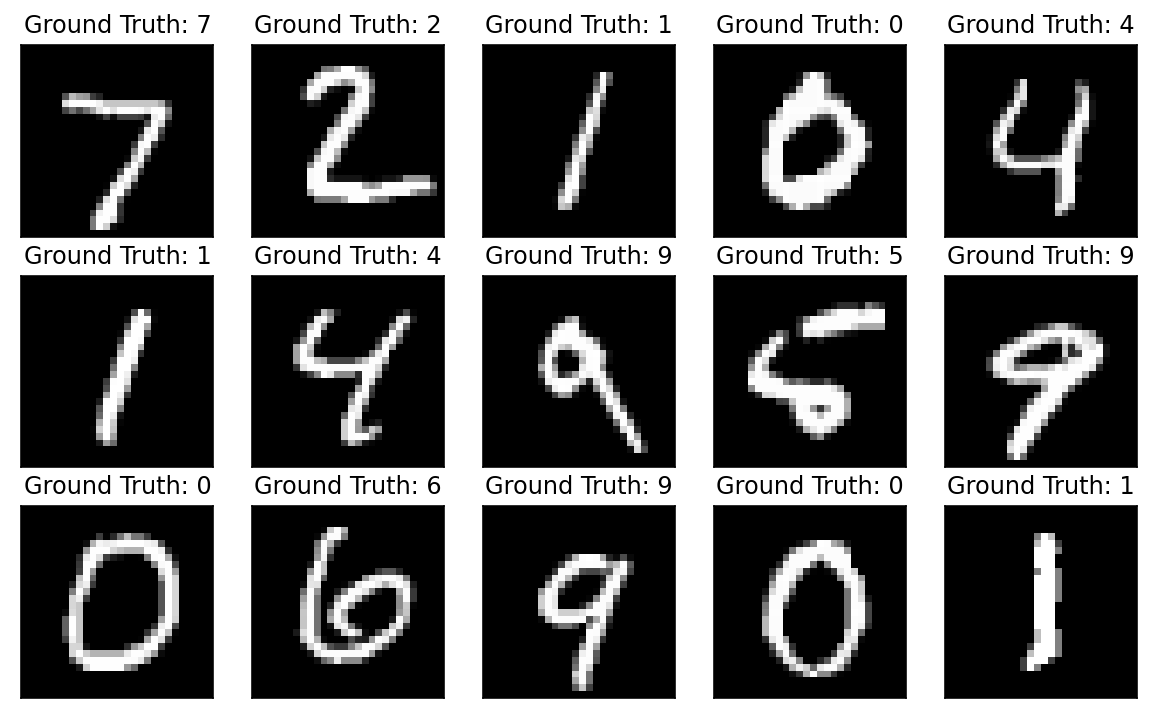

In [6]:
#plot images of dataset

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(10,6))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [7]:
#@title CNN Arquitecture
#CNN Architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return(x)

In [8]:
ce_loss = nn.CrossEntropyLoss().to(device)

In [9]:
#@title test method
def test(net, loss_function, loader):
  net.eval()
  test_loss = 0
  correct = 0
  
  with torch.no_grad():
    for data, target in loader:
      data, target = data.to(device), target.to(device)
      output = net(data)
      test_loss += loss_function(output, target)
      _, pred = torch.max(output, 1)  
      correct += pred.eq(target).cpu().sum().item() 
  acc = 100.*correct/len(loader.dataset)
  test_loss /= len(loader)
  
  return acc, test_loss

In [10]:
#@title evaluate method

def eval(net, loader):
  net.eval()
  
  losses = torch.zeros(len(loader.dataset))    
  CE = nn.CrossEntropyLoss(reduction='none')
  with torch.no_grad():
    for i ,(images,labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = CE(outputs, labels)
        for b in range(images.size(0)):
          idx = batch_size*i+b
          losses[idx]=loss[b] 
  
  losses = (losses-losses.min())/(losses.max()-losses.min())    
  input_loss = losses.reshape(-1,1)

  # fit a two-component GMM to the loss
  gmm = GaussianMixture(n_components=2,max_iter=50,tol=1e-2,reg_covar=5e-4)
  gmm.fit(input_loss)
  prob = gmm.predict_proba(input_loss) 
  prob = prob[:,gmm.means_.argmin()] 
  return losses, prob



In [11]:
def train_epoch(net, loss_function, dataloader, optimizer):
  train_loss = train_acc = correct = 0
  net.train()
  for i ,(images,labels) in enumerate(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    train_loss+= loss
    loss.backward()

    optimizer.step()

    _, pred = torch.max(outputs, 1)  
    correct += pred.eq(labels).cpu().sum().item() 
        
  train_loss/=len(dataloader)
  train_acc=100.*correct/len(dataloader.dataset)
  return train_loss, train_acc

In [12]:
def train_test_model(loss_function):
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  logs={'train_loss':[],'train_acc':[], 'test_loss':[], 'test_acc':[],'eval_loss':[]}

  for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(net, loss_function, train_loader, optimizer)
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)

    eval_loss, _ = eval(net, eval_loader)
    logs['eval_loss'].append(eval_loss.cpu().numpy())
    
    acc_test, loss_test=test(net, loss_function, test_loader)
    logs['test_loss'].append(loss_test)
    logs['test_acc'].append(acc_test)

    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
  return logs


# Run Baseline

In [13]:
#run baseline
logs_baseline = train_test_model(ce_loss)

Epoch [0/50],	train loss:2.2705,	train acc:15.10,	test loss:2.1540,	test accuracy:45.37
Epoch [1/50],	train loss:2.0459,	train acc:28.35,	test loss:1.6735,	test accuracy:60.41
Epoch [2/50],	train loss:1.6441,	train acc:43.95,	test loss:1.0557,	test accuracy:78.46
Epoch [3/50],	train loss:1.2998,	train acc:58.00,	test loss:0.7412,	test accuracy:84.94
Epoch [4/50],	train loss:1.0904,	train acc:64.65,	test loss:0.5301,	test accuracy:87.83
Epoch [5/50],	train loss:0.9177,	train acc:70.85,	test loss:0.4593,	test accuracy:89.04
Epoch [6/50],	train loss:0.8333,	train acc:73.35,	test loss:0.3844,	test accuracy:90.99
Epoch [7/50],	train loss:0.7561,	train acc:76.15,	test loss:0.3290,	test accuracy:91.40
Epoch [8/50],	train loss:0.7050,	train acc:76.85,	test loss:0.3098,	test accuracy:91.79
Epoch [9/50],	train loss:0.6336,	train acc:80.35,	test loss:0.2789,	test accuracy:92.45
Epoch [10/50],	train loss:0.6522,	train acc:78.90,	test loss:0.2658,	test accuracy:92.83
Epoch [11/50],	train loss:0.644

In [14]:
logs_baseline['train_loss'] = [x.cpu().detach().numpy() for x in logs_baseline['train_loss']] 
logs_baseline['test_loss'] = [x.cpu().detach().numpy() for x in logs_baseline['test_loss']] 

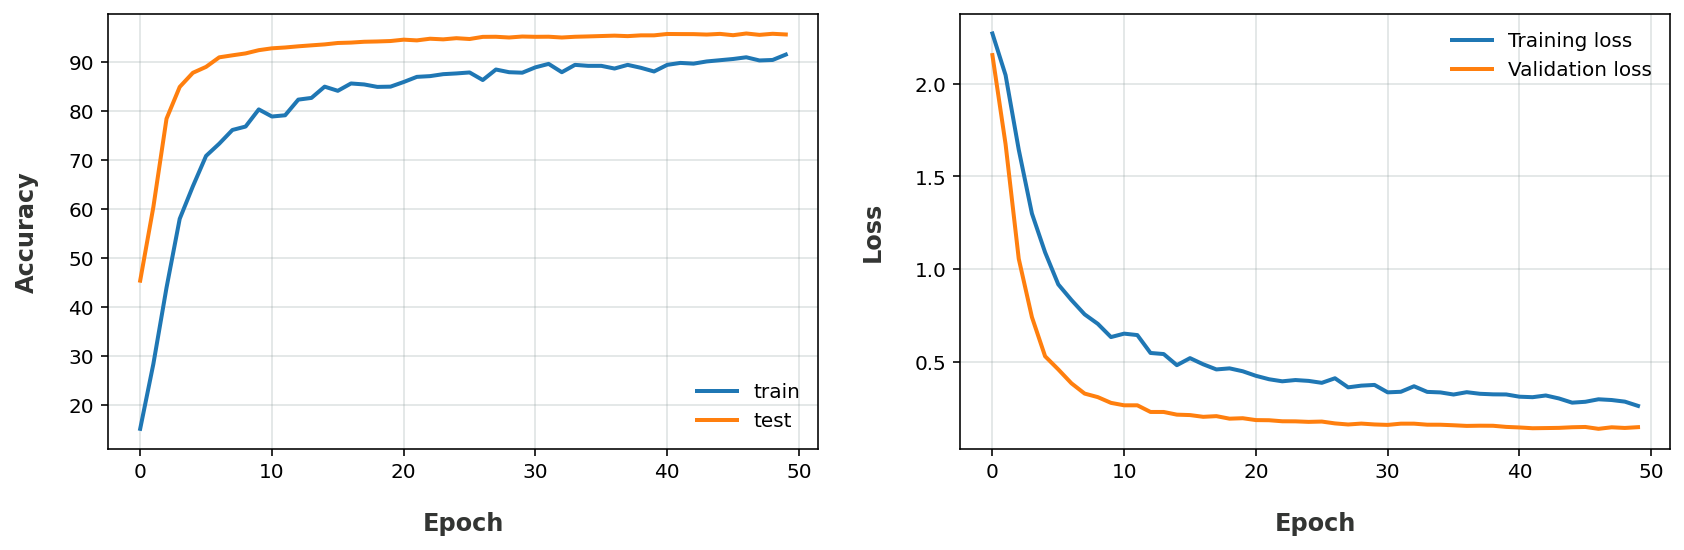

In [15]:
fig = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(logs_baseline['train_acc'], label='train', linewidth=2)
plt.plot(logs_baseline['test_acc'], label='test', linewidth=2)
plt.legend(frameon=False)
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');

plt.subplot(1,2,2)
plt.plot(logs_baseline['train_loss'], label='Training loss', linewidth=2)
plt.plot(logs_baseline['test_loss'], label='Validation loss', linewidth=2)
plt.legend(frameon=False)
# plt.grid()
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.ylabel("Loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');


# Generate Noisy MNIST

Build synthetic noise benchmark on MNIST

In [16]:
gt_labels = train_data.targets.clone()   #ground truth labels (clean)

In [17]:
##generate noise

transition = {0:0,2:0,4:7,7:7,1:1,9:1,3:5,5:3,6:6,8:8} # class transition for asymmetric noise

def generate_noise(nr, gt_labels, noise_mode='sym'):
  noise_label = []
  idx = list(range(len(gt_labels)))
  random.shuffle(idx)
  num_noise = int(nr*len(gt_labels))            
  noise_idx = idx[:num_noise]
  for i in range(len(gt_labels)):
      if i in noise_idx:
        if noise_mode=='sym':
          noiselabel = random.randint(0,9)  
          noise_label.append(noiselabel)
        elif noise_mode=='asym':   
          noiselabel = transition[gt_labels[i].item()]
          noise_label.append(noiselabel)                    
      else:    
        noise_label.append(gt_labels[i])  
  return torch.tensor(noise_label)

In [18]:
#generate noisy_benchmark
label_noise={}
label_noise['50_sym']=generate_noise(0.5, gt_labels, 'sym')
label_noise['70_sym']=generate_noise(0.7, gt_labels, 'sym')
label_noise['40_asym']=generate_noise(0.4, gt_labels, 'asym')

In [19]:
# real noise rate (sym) = prob. of flipping * noise rate
# e.g. for 70 % symmetric NR, RNR = 0.9*0.7 = 0.63
print('real noise rate:{:.2f}'.format((np.array(label_noise['70_sym'])!=np.array(gt_labels)).sum()/len(gt_labels)))

real noise rate:0.63


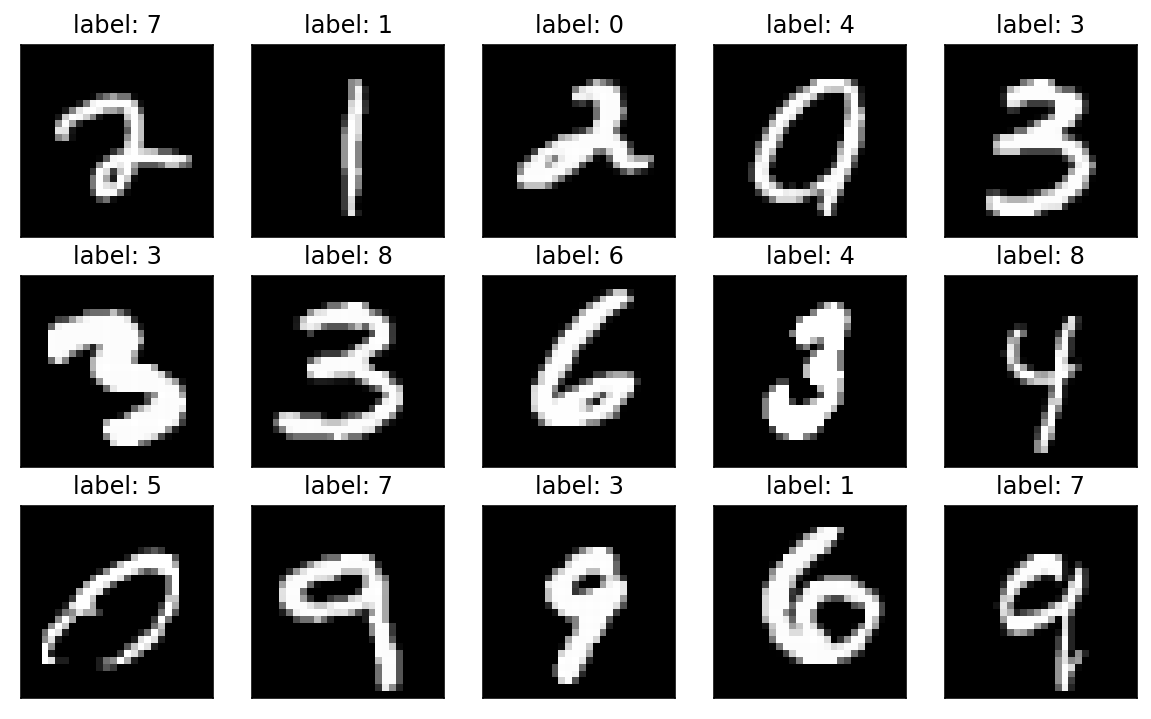

In [20]:
#plot images of dataset

# train_data.targets = label_noise['70_sym']  #update current labels
train_loader.dataset.targets = label_noise['70_sym'].clone()
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(10,6))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [21]:
noisy_map = np.zeros((10, 10))
nl = label_noise['40_asym']
for i in range(len(gt_labels)):
  noisy_map[int(nl[i])][int(gt_labels[i])] += 1

#calculate de percentage. Divides each element by the sum of the row
percent_map = noisy_map/noisy_map.sum(axis=0, keepdims=True)

Text(0.5, 33.0, 'true labels')

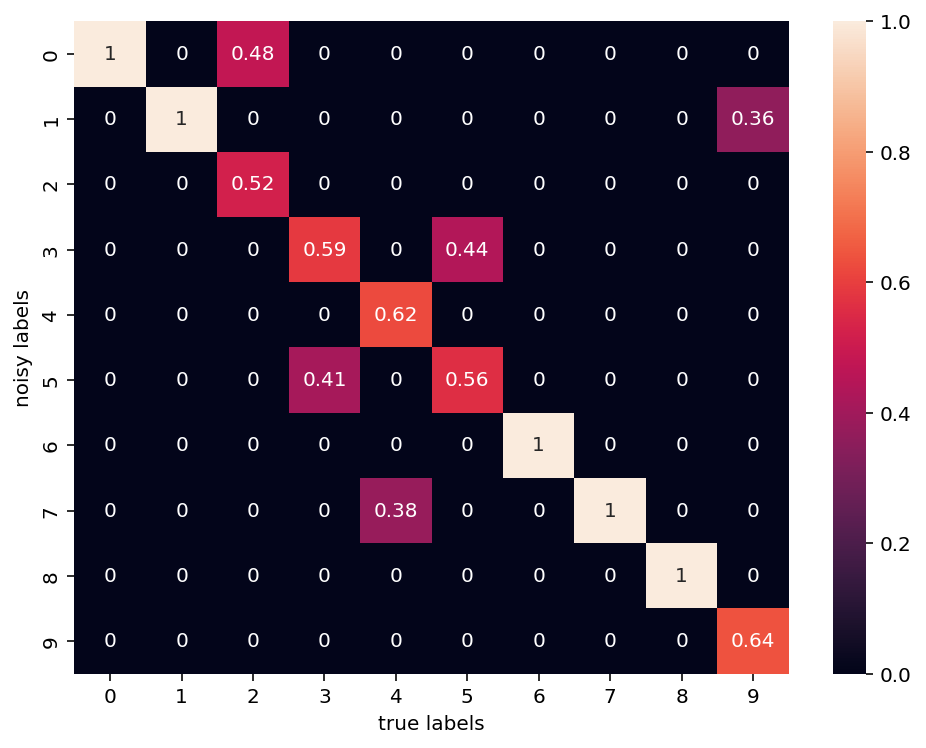

In [22]:
df_cm = pd.DataFrame(percent_map, index = [0,1,2,3,4,5,6,7,8,9],
                  columns = list(range(10)))
plt.figure(figsize = (8,6))

sn.heatmap(df_cm, annot=True)
plt.ylabel('noisy labels')
plt.xlabel('true labels')


In [23]:
unique_elements, counts_elements = np.unique(nl, return_counts=True)
# unique_elements, counts_elements = np.unique(gt_labels, return_counts=True)

<BarContainer object of 10 artists>

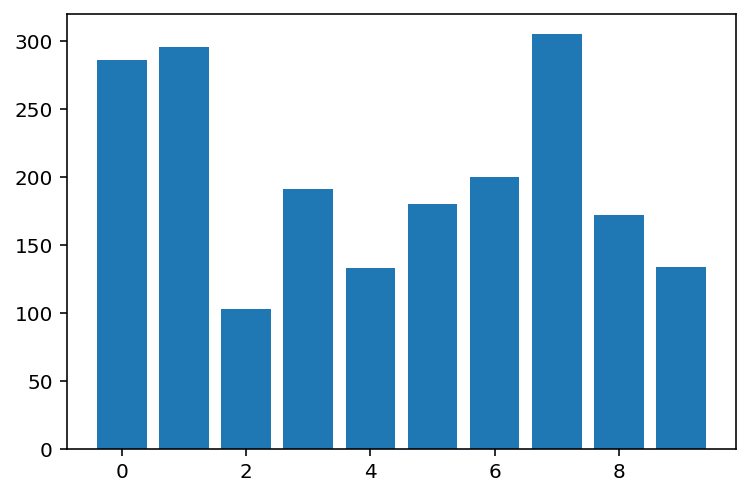

In [24]:
plt.bar(unique_elements,counts_elements)

## Train noisy baseline

In [25]:
#train with 50% noise rate
train_loader.dataset.targets = label_noise['50_sym'].clone()  #update current labels
logs_nb_50_sym = train_test_model(ce_loss)

Epoch [0/50],	train loss:2.3031,	train acc:10.45,	test loss:2.2588,	test accuracy:31.86
Epoch [1/50],	train loss:2.2710,	train acc:15.50,	test loss:2.1596,	test accuracy:47.31
Epoch [2/50],	train loss:2.2258,	train acc:19.75,	test loss:1.9971,	test accuracy:62.65
Epoch [3/50],	train loss:2.1654,	train acc:24.90,	test loss:1.8353,	test accuracy:64.72
Epoch [4/50],	train loss:2.1164,	train acc:30.20,	test loss:1.5985,	test accuracy:77.15
Epoch [5/50],	train loss:2.0651,	train acc:32.85,	test loss:1.5145,	test accuracy:81.88
Epoch [6/50],	train loss:2.0361,	train acc:35.40,	test loss:1.4556,	test accuracy:82.09
Epoch [7/50],	train loss:2.0049,	train acc:37.85,	test loss:1.3649,	test accuracy:85.03
Epoch [8/50],	train loss:2.0174,	train acc:38.35,	test loss:1.3622,	test accuracy:85.82
Epoch [9/50],	train loss:1.9952,	train acc:38.75,	test loss:1.2916,	test accuracy:88.55
Epoch [10/50],	train loss:1.9533,	train acc:41.05,	test loss:1.2304,	test accuracy:88.90
Epoch [11/50],	train loss:1.949

In [26]:
#train with 50% noise rate
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
logs_nb_70_sym = train_test_model(ce_loss)

Epoch [0/50],	train loss:2.3082,	train acc:11.10,	test loss:2.2893,	test accuracy:15.03
Epoch [1/50],	train loss:2.2966,	train acc:11.60,	test loss:2.2668,	test accuracy:20.94
Epoch [2/50],	train loss:2.2844,	train acc:13.40,	test loss:2.2227,	test accuracy:29.02
Epoch [3/50],	train loss:2.2797,	train acc:13.10,	test loss:2.1791,	test accuracy:50.85
Epoch [4/50],	train loss:2.2672,	train acc:15.95,	test loss:2.1147,	test accuracy:55.12
Epoch [5/50],	train loss:2.2523,	train acc:17.05,	test loss:2.0210,	test accuracy:57.73
Epoch [6/50],	train loss:2.2430,	train acc:19.25,	test loss:1.9789,	test accuracy:58.31
Epoch [7/50],	train loss:2.2256,	train acc:18.85,	test loss:1.9087,	test accuracy:64.59
Epoch [8/50],	train loss:2.2189,	train acc:21.40,	test loss:1.8735,	test accuracy:71.83
Epoch [9/50],	train loss:2.1987,	train acc:21.50,	test loss:1.8263,	test accuracy:75.03
Epoch [10/50],	train loss:2.1935,	train acc:23.50,	test loss:1.8200,	test accuracy:77.81
Epoch [11/50],	train loss:2.181

In [27]:
#train with 40% asym. noise rate
train_loader.dataset.targets = label_noise['40_asym'].clone()  #update current labels
logs_nb_40_asym = train_test_model(ce_loss)

Epoch [0/50],	train loss:2.2487,	train acc:15.45,	test loss:2.2127,	test accuracy:30.70
Epoch [1/50],	train loss:2.0949,	train acc:26.95,	test loss:1.9385,	test accuracy:39.42
Epoch [2/50],	train loss:1.8489,	train acc:37.85,	test loss:1.4849,	test accuracy:55.10
Epoch [3/50],	train loss:1.6200,	train acc:46.95,	test loss:1.2079,	test accuracy:65.86
Epoch [4/50],	train loss:1.4250,	train acc:52.95,	test loss:0.9512,	test accuracy:70.87
Epoch [5/50],	train loss:1.2883,	train acc:56.55,	test loss:0.9239,	test accuracy:68.59
Epoch [6/50],	train loss:1.2105,	train acc:57.80,	test loss:0.8105,	test accuracy:75.50
Epoch [7/50],	train loss:1.1056,	train acc:59.60,	test loss:0.6960,	test accuracy:78.15
Epoch [8/50],	train loss:1.0570,	train acc:60.50,	test loss:0.7048,	test accuracy:74.44
Epoch [9/50],	train loss:1.0135,	train acc:63.10,	test loss:0.6502,	test accuracy:79.59
Epoch [10/50],	train loss:1.0033,	train acc:61.65,	test loss:0.6630,	test accuracy:77.06
Epoch [11/50],	train loss:0.940

In [28]:
def convert_to_numpy(log):
    return [x.detach().cpu().numpy() for x in log]
logs_nb_50_sym['train_loss'] = convert_to_numpy(logs_nb_50_sym['train_loss'])
logs_nb_70_sym['train_loss'] = convert_to_numpy(logs_nb_70_sym['train_loss'])
logs_nb_40_asym['train_loss'] = convert_to_numpy(logs_nb_40_asym['train_loss'])
logs_nb_50_sym['test_loss'] = convert_to_numpy(logs_nb_50_sym['test_loss'])
logs_nb_70_sym['test_loss'] = convert_to_numpy(logs_nb_70_sym['test_loss'])
logs_nb_40_asym['test_loss'] = convert_to_numpy(logs_nb_40_asym['test_loss'])
            


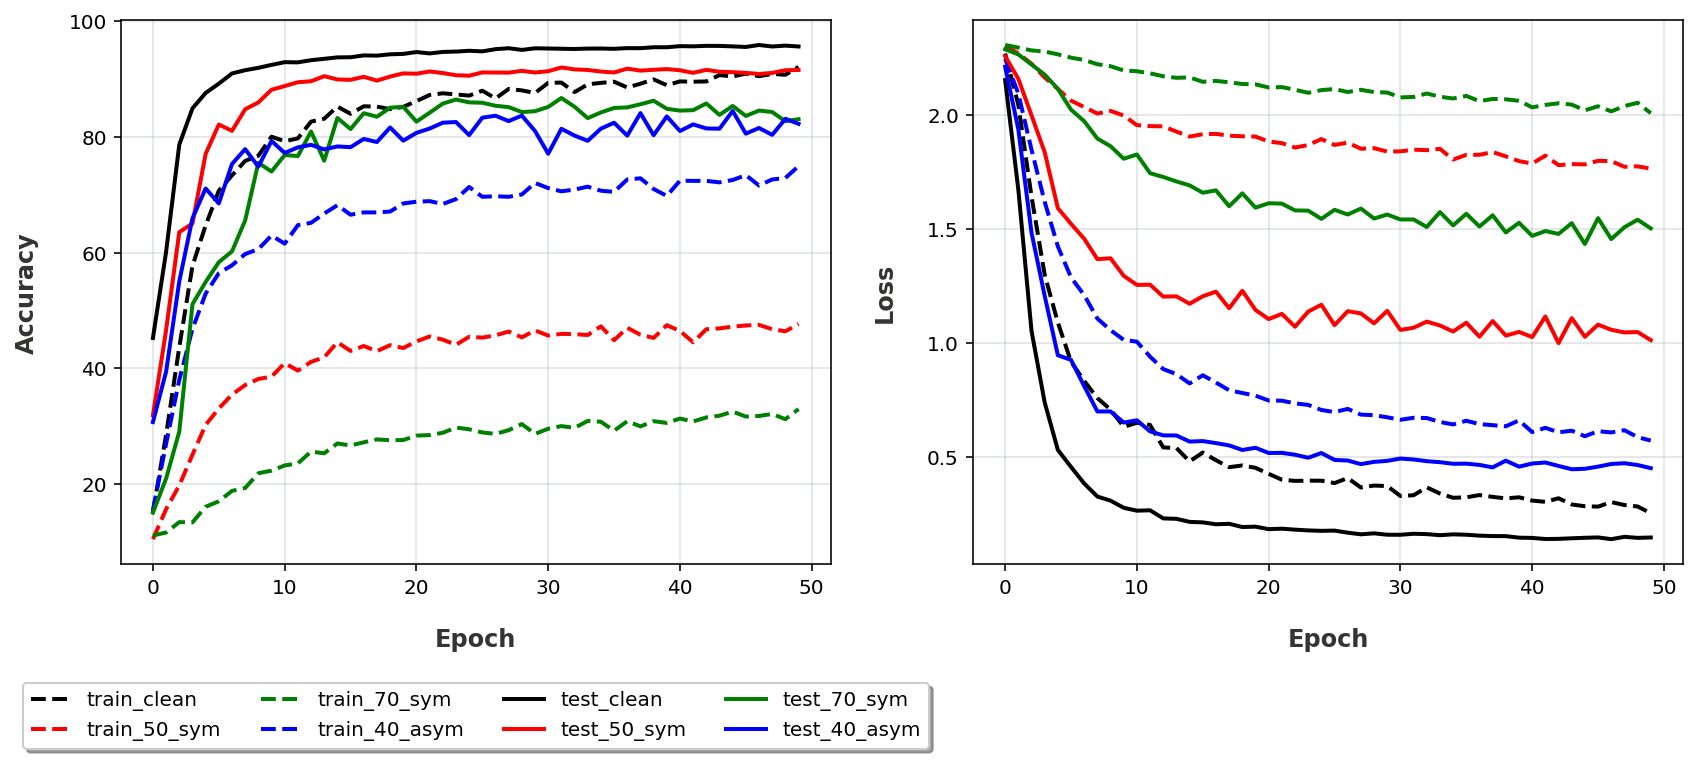

In [51]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(logs_baseline['train_acc'], label='train_clean', linewidth=2, linestyle='--',color='k')
plt.plot(logs_nb_50_sym['train_acc'], label='train_50_sym', linewidth=2, linestyle='--', color='r')
plt.plot(logs_nb_70_sym['train_acc'], label='train_70_sym', linewidth=2, linestyle='--', color='g')
plt.plot(logs_nb_40_asym['train_acc'], label='train_40_asym', linewidth=2, linestyle='--', color='b')
plt.plot(logs_baseline['test_acc'], label='test_clean', linewidth=2, color='k')
plt.plot(logs_nb_50_sym['test_acc'], label='test_50_sym', linewidth=2, color='r')
plt.plot(logs_nb_70_sym['test_acc'], label='test_70_sym', linewidth=2, color='g')
plt.plot(logs_nb_40_asym['test_acc'], label='test_40_asym', linewidth=2, color='b')
# plt.legend(frameon=False)
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.subplot(1,2,2)
plt.plot(logs_baseline['train_loss'], label='train_clean', linewidth=2, linestyle='--',color='k')
plt.plot(logs_nb_50_sym['train_loss'], label='train_50_sym', linewidth=2, linestyle='--', color='r')
plt.plot(logs_nb_70_sym['train_loss'], label='train_70_sym', linewidth=2, linestyle='--', color='g')
plt.plot(logs_nb_40_asym['train_loss'], label='train_40_asym', linewidth=2, linestyle='--', color='b')
plt.plot(logs_baseline['test_loss'], label='test_clean', linewidth=2, color='k')
plt.plot(logs_nb_50_sym['test_loss'], label='test_50_sym', linewidth=2, color='r')
plt.plot(logs_nb_70_sym['test_loss'], label='test_70_sym', linewidth=2, color='g')
plt.plot(logs_nb_40_asym['test_loss'], label='test_40_asym', linewidth=2, color='b')
# plt.legend(frameon=False)
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.ylabel("Loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');

# Combating Noisy Labels

## Robust Loss

In [29]:
#Active Passive Loss (ICML 2020)
#paper code: https://github.com/HanxunH/Active-Passive-Losses

In [30]:
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes=10, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float()
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

In [31]:
class ReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))
        return self.scale * rce.mean()

In [32]:
class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha=0.1, beta=1, num_classes=10):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)

In [33]:
class NormalizedFocalLoss(torch.nn.Module):
    def __init__(self, scale=1.0, gamma=0, num_classes=10, alpha=None, size_average=True):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input, target):
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        normalizor = torch.sum(-1 * (1 - logpt.data.exp()) ** self.gamma * logpt, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.autograd.Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        loss = self.scale * loss / normalizor

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [34]:
class NFLandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10, gamma=0.5):
        super(NFLandRCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.rce(pred, labels)

In [35]:
class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        # Note: Reduced MAE
        # Original: torch.abs(pred - label_one_hot).sum(dim=1)
        # $MAE = \sum_{k=1}^{K} |\bm{p}(k|\bm{x}) - \bm{q}(k|\bm{x})|$
        # $MAE = \sum_{k=1}^{K}\bm{p}(k|\bm{x}) - p(y|\bm{x}) + (1 - p(y|\bm{x}))$
        # $MAE = 2 - 2p(y|\bm{x})$
        #
        return self.scale * mae.mean()

In [36]:
class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

### Train with APL 

In [37]:
#train with 70% noise rate
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
criterion =NCEandMAE(alpha=1, beta=1)
logs_apl_70_sym = train_test_model(criterion)

Epoch [0/50],	train loss:0.9997,	train acc:9.80,	test loss:0.9939,	test accuracy:11.72
Epoch [1/50],	train loss:0.9940,	train acc:11.00,	test loss:0.9784,	test accuracy:17.13
Epoch [2/50],	train loss:0.9854,	train acc:12.25,	test loss:0.9371,	test accuracy:26.04
Epoch [3/50],	train loss:0.9688,	train acc:13.35,	test loss:0.8640,	test accuracy:25.63
Epoch [4/50],	train loss:0.9659,	train acc:12.55,	test loss:0.7538,	test accuracy:41.21
Epoch [5/50],	train loss:0.9377,	train acc:16.25,	test loss:0.6577,	test accuracy:47.38
Epoch [6/50],	train loss:0.9165,	train acc:18.65,	test loss:0.5890,	test accuracy:49.58
Epoch [7/50],	train loss:0.9004,	train acc:20.15,	test loss:0.5329,	test accuracy:59.19
Epoch [8/50],	train loss:0.8863,	train acc:21.30,	test loss:0.5223,	test accuracy:57.91
Epoch [9/50],	train loss:0.8765,	train acc:21.65,	test loss:0.4867,	test accuracy:59.42
Epoch [10/50],	train loss:0.8670,	train acc:22.60,	test loss:0.4472,	test accuracy:61.26
Epoch [11/50],	train loss:0.8579

(70.0, 100.0)

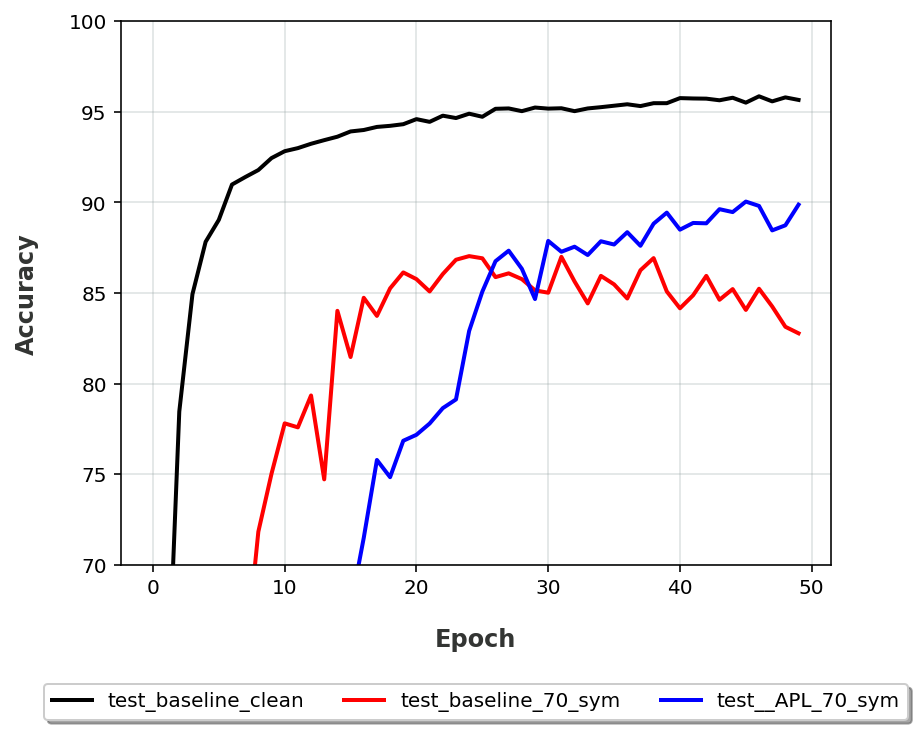

In [38]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(logs_baseline['test_acc'], label='test_baseline_clean', linewidth=2, color='k')
plt.plot(logs_nb_70_sym['test_acc'], label='test_baseline_70_sym', linewidth=2, color='r')
plt.plot(logs_apl_70_sym['test_acc'], label='test__APL_70_sym', linewidth=2, color='b')
# plt.plot(logs_nb_40_asym['test_acc'], label='test_40_asym', linewidth=2, color='b')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)
plt.ylim(70, 100,10)


### small-loss trick

In [39]:
# noisy_labels = label_noise['70_sym']
nl = label_noise['70_sym']
inds_noisy = np.asarray([ind for ind in range(len(nl)) if nl[ind] != gt_labels[ind]])
inds_clean = np.delete(np.arange(len(nl)), inds_noisy)

As training increases, loss from clean and noisy samples can be seen to be separating out. So the data can be split *based on the loss value.* This is what *Arazo et al (2019)* do. 

However, this can not be started straight away from epoch 0 as the loss is not separated well enough yet. So there needs to be a warm-up phase of say, 15 epochs, before we start using the small-loss trick.

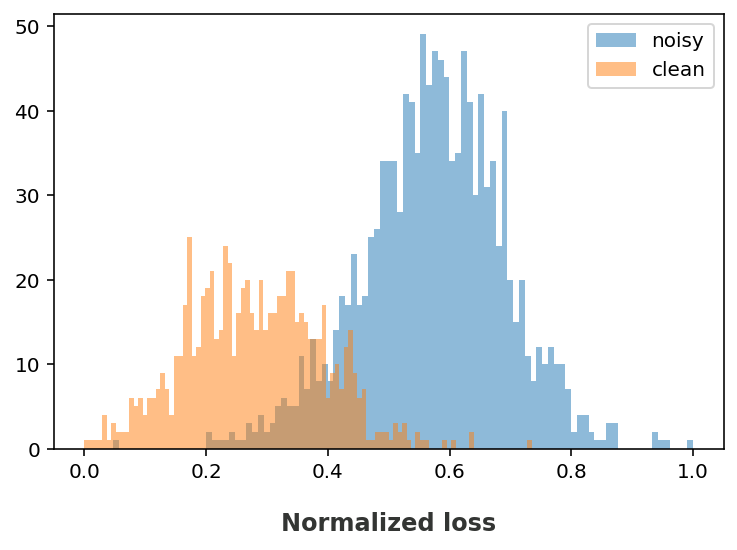

In [40]:
plt.hist(logs_nb_70_sym['eval_loss'][-1][inds_noisy],label='noisy',bins=100,alpha=0.5)
plt.hist(logs_nb_70_sym['eval_loss'][-1][inds_clean],label='clean',bins=100,alpha=0.5)
plt.xlabel("Normalized loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend()

In [41]:
avg_loss_clean = [logs_nb_70_sym['eval_loss'][i][inds_clean].mean() for i in range(num_epochs)]
avg_loss_noisy = [logs_nb_70_sym['eval_loss'][i][inds_noisy].mean() for i in range(num_epochs)]

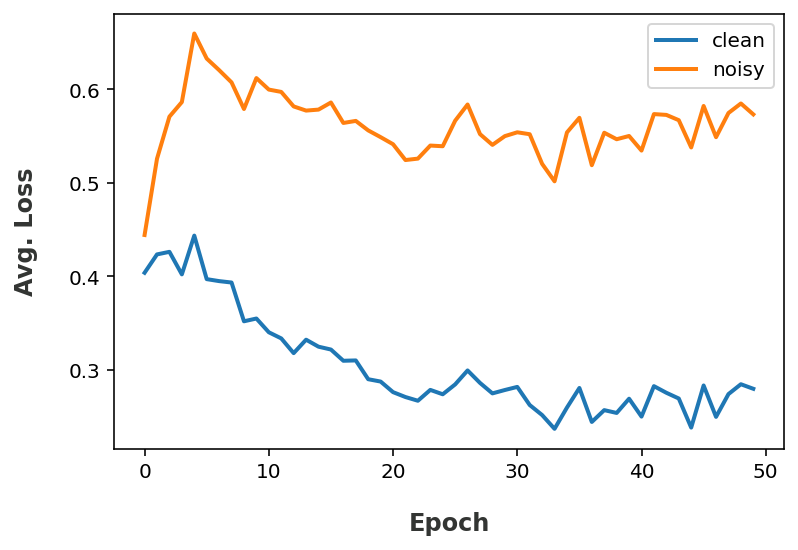

In [42]:
plt.plot(avg_loss_clean, label='clean',linewidth=2)
plt.plot(avg_loss_noisy, label='noisy',linewidth=2)
plt.ylabel("Avg. Loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend()

## Remove Noisy Samples

In [46]:
def train_test_filtering(loss_function,trainloader):
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  logs={'train_loss':[],'train_acc':[], 'test_loss':[], 'test_acc':[],'eval_loss':[]}

  for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(net, loss_function, trainloader, optimizer)
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    eval_loss, prob = eval(net, eval_loader)
    logs['eval_loss'].append(eval_loss)
    
    acc_test, loss_test=test(net, loss_function, test_loader)
    logs['test_loss'].append(loss_test)
    logs['test_acc'].append(acc_test)

    if epoch>10: #10 epochs to warm up
      pred_idx_clean = (prob > 0.5).nonzero()[0]
      
      train_clean = Subset(train_data, pred_idx_clean)    #get the subset of samples predicted as clean
      clean_loader = torch.utils.data.DataLoader(train_clean,
                                              batch_size = batch_size,
                                              shuffle = True,num_workers=1,pin_memory=False)
      trainloader=clean_loader

    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
  
  return logs

In [47]:
#train with 70% sym noise
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
logs_remove_70_sym = train_test_filtering(ce_loss,train_loader)

Epoch [0/50],	train loss:2.3082,	train acc:11.10,	test loss:2.2893,	test accuracy:15.03
Epoch [1/50],	train loss:2.2966,	train acc:11.60,	test loss:2.2668,	test accuracy:20.62
Epoch [2/50],	train loss:2.2846,	train acc:13.40,	test loss:2.2229,	test accuracy:29.29
Epoch [3/50],	train loss:2.2797,	train acc:13.10,	test loss:2.1799,	test accuracy:51.86
Epoch [4/50],	train loss:2.2670,	train acc:15.75,	test loss:2.1137,	test accuracy:53.49
Epoch [5/50],	train loss:2.2512,	train acc:17.35,	test loss:2.0196,	test accuracy:60.23
Epoch [6/50],	train loss:2.2431,	train acc:18.85,	test loss:1.9808,	test accuracy:61.60
Epoch [7/50],	train loss:2.2250,	train acc:19.85,	test loss:1.8909,	test accuracy:67.30
Epoch [8/50],	train loss:2.2209,	train acc:21.05,	test loss:1.8793,	test accuracy:74.02
Epoch [9/50],	train loss:2.2020,	train acc:21.80,	test loss:1.8322,	test accuracy:73.52
Epoch [10/50],	train loss:2.1928,	train acc:23.80,	test loss:1.8175,	test accuracy:76.28
Epoch [11/50],	train loss:2.181

(70.0, 100.0)

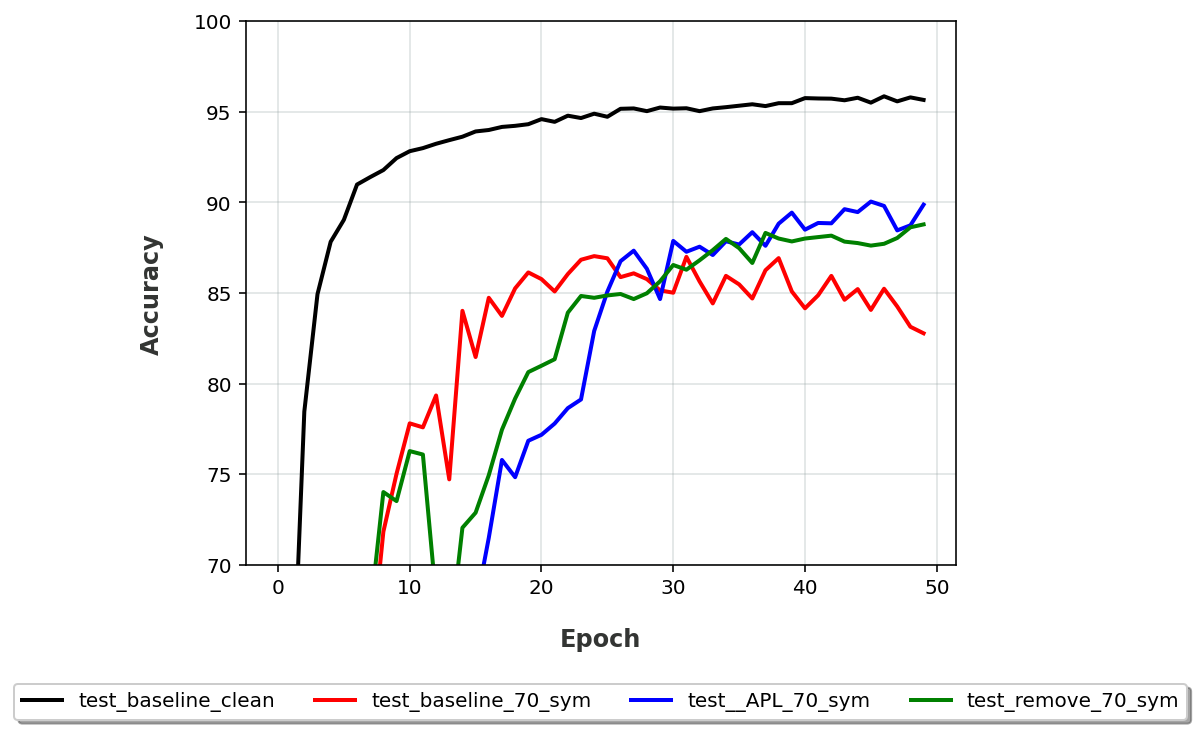

In [48]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(logs_baseline['test_acc'], label='test_baseline_clean', linewidth=2, color='k')
plt.plot(logs_nb_70_sym['test_acc'], label='test_baseline_70_sym', linewidth=2, color='r')
plt.plot(logs_apl_70_sym['test_acc'], label='test__APL_70_sym', linewidth=2, color='b')
plt.plot(logs_remove_70_sym['test_acc'], label='test_remove_70_sym', linewidth=2, color='g')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)
plt.ylim(70, 100,10)